In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit



# Material properties
E = 193e9  # Young's modulus in Pascals
sigma_y = 150e6  # Yield stress in Pascals
H = 10e6  # Hardening modulus in Pascals


def generate_strain_history(num_samples, lb, ub):
    """
    Generate a cyclic strain history.

    :param num_samples: Total number of samples
    :param lb: Lower bound for strain increment
    :param ub: Upper bound for strain increment
    :return: Strain history
    """
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history


def compute_stress(strain_increment, stress_prev, alpha_prev):
    """
    Compute the updated stress and internal variables for a uniaxial stress field.

    :param strain_increment: Increment of strain
    :param stress_prev: Previous stress state
    :param alpha_prev: Previous equivalent plastic strain
    :return: Updated stress, plastic strain increment, and equivalent plastic strain
    """
    # Elastic predictor
    trial_stress = stress_prev + E * strain_increment

    # Yield function
    f_trial = abs(trial_stress) - (sigma_y + H * alpha_prev)

    if f_trial <= 0:
        # Elastic step
        return trial_stress, 0.0, alpha_prev, f_trial
    else:
        # Plastic correction (return mapping)
        delta_lambda = f_trial / (E + H)
        plastic_strain_increment = delta_lambda
        alpha_updated = alpha_prev + delta_lambda

        # Corrected stress
        #stress_corrected = (sigma_y + H * alpha_updated) * (1 if trial_stress > 0 else -1)
        stress_corrected = trial_stress-E*delta_lambda* (1 if trial_stress > 0 else -1)

        return stress_corrected, plastic_strain_increment, alpha_updated, f_trial

# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)
        
    # Simulate the stress-strain response
    stress_history = np.zeros(num_strain_samples)
    plastic_strain_history = np.zeros(num_strain_samples)
    alpha_history = np.zeros(num_strain_samples)

    stress_prev = 0.0  # Initial stress
    alpha_prev = 0.0  # Initial equivalent plastic strain

    for i in range(1, num_strain_samples):
        strain_increment = strain_history[i] - strain_history[i - 1]
        stress, plastic_strain_increment, alpha, f_trial = compute_stress(strain_increment, stress_prev, alpha_prev)

        stress_history[i] = stress
        plastic_strain_history[i] = plastic_strain_increment
        alpha_history[i] = alpha

        stress_prev = stress
        alpha_prev = alpha

        # Store the data
        dataset.append([
            E, sigma_y,
            H, f_trial,strain_history[i],strain_increment, plastic_strain_history[i], stress, alpha
        ])

    return np.array(dataset)



In [2]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [3]:
columns = ["E", "sigma_y","H", "f_trial","strain_history",
           "strain_increment", "plastic_strain_history", "stress", "alpha"]
df = pd.DataFrame(training, columns=columns)

In [4]:
df.head(5)

,E,sigma_y,H,f_trial,strain_history,strain_increment,plastic_strain_history,stress,alpha
0,1.930000e+11,150000000.0,10000000.0,-1.122552e+08,0.000392,0.000196,0.000000,3.774484e+07,0.000000
1,1.930000e+11,150000000.0,10000000.0,-8.707516e+07,0.000522,0.000130,0.000000,6.292484e+07,0.000000
2,1.930000e+11,150000000.0,10000000.0,-5.555389e+07,0.000686,0.000163,0.000000,9.444611e+07,0.000000
3,1.930000e+11,150000000.0,10000000.0,-2.597470e+07,0.000839,0.000153,0.000000,1.240253e+08,0.000000
4,1.930000e+11,150000000.0,10000000.0,6.956557e+06,0.001009,0.000171,0.000036,1.500004e+08,0.000036


In [5]:
plastic_strain_training= training[:,-3]
plastic_strain_test1= test1[:,-3]
plastic_strain_test2= test2[:,-3]

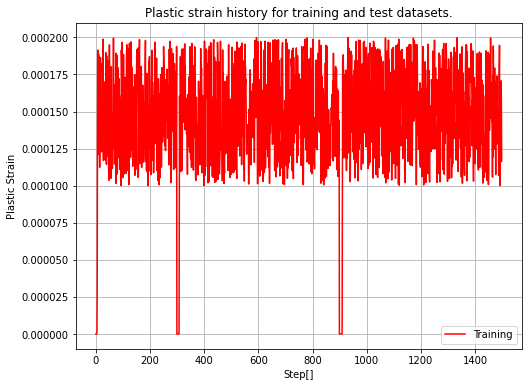

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(plastic_strain_training, label='Training', color='red')
#plt.plot(plastic_strain_test1, label='Test1', color='blue')
#plt.plot(plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [71]:
strain_training= training[:,4]
strain_test1= test1[:,4]
strain_test2= test2[:,4]

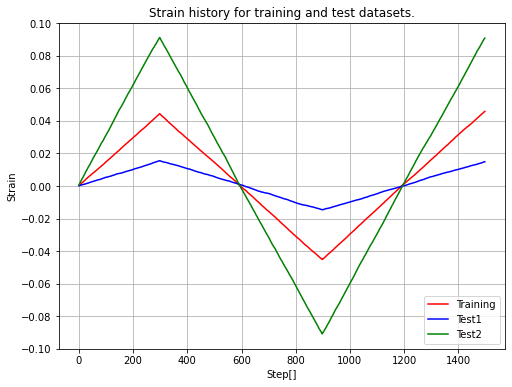

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.plot(strain_test1, label='Test1', color='blue')
plt.plot(strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [73]:
strain_training_increment= training[:,5]
strain_test1_increment= test1[:,5]
strain_test2_increment= test2[:,5]

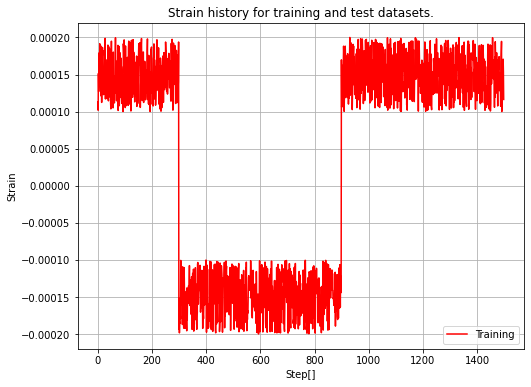

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training_increment, label='Training', color='red')
#plt.plot(strain_test1_increment, label='Test1', color='blue')
#plt.plot(strain_test2_increment, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [75]:
Tial_phi_training= training[:,3]
Tial_phi_test1= test1[:,3]
Tial_phi_test2= test2[:,3]

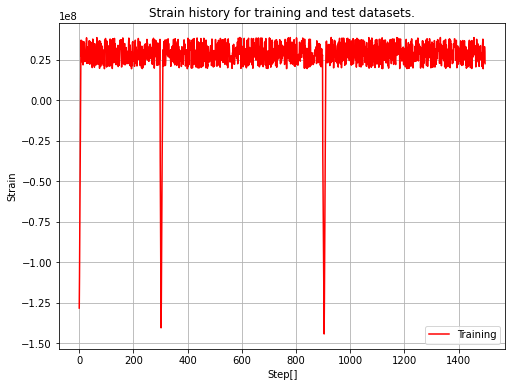

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(Tial_phi_training, label='Training', color='red')
#plt.plot(Tial_phi_test1, label='Test1', color='blue')
#plt.plot(Tial_phi_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

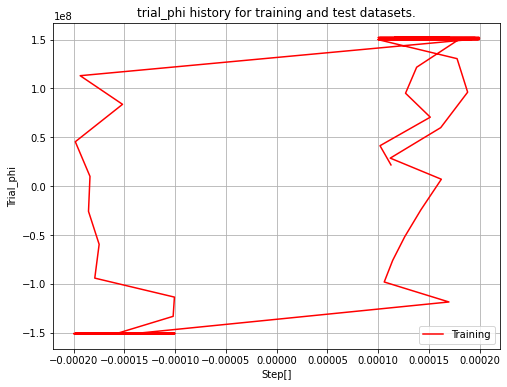

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,5], training[:,-2], label='Training', color='red')
#plt.plot(test1[:,5], test1[:,-2], label='Test1', color='blue')
#plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Trial_phi')
plt.title('trial_phi history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [78]:
alpha_training= training[:,3]
alpha_test1= test1[:,3]
alpha_test2= test2[:,3]

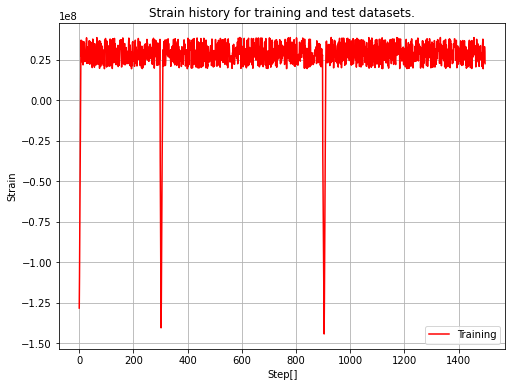

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(alpha_training, label='Training', color='red')
#plt.plot(alpha_test1, label='Test1', color='blue')
#plt.plot(alpha_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [80]:
print(np.isnan(training).any())
print(np.isinf(training).any())

False
False
